# Looking at the correlation between cloud fraction and the calculated feedback parameters

### Add paths to run locally or off NIRD

In [1]:
import sys
# Add common resources folder to path
sys.path.append("/mnt/mcc-ns9600k/jonahks/git_repos/netcdf_analysis/Common/")
sys.path.append("/mnt/mcc-ns9600k/jonahks/git_repos/netcdf_analysis/")
sys.path.append("/home/jonahks/git_repos/netcdf_analysis/")
sys.path.append("/home/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, sys, crt, gridspec,
    ccrs, metrics, Iterable
    )

from functions import (
    masked_average, add_weights, sp_map,
    season_mean, get_dpm, leap_year, share_ylims,
    to_png, mute_ax
    )

from classes import SatComp_Metric, CT_SLF_Metric
from collections import deque
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load feedback specific functions

In [2]:
from feedback_functions import *

### Check running location and adjust working directory appropriately.

In [3]:
host = os.uname()[1]
if 'jupyter' in host.split('-'): # Check if running on NIRD through the Jupyter Hub
    print('Running through MC2 Jupyter Hub')
    model_dir = '/mnt/mcc-ns9600k/jonahks/'
    os.chdir(model_dir)

else:  # Assume that we're running on a local machine and mounting NIRD
    print('Running on %s, attempting to mount ns9600k/jonahks/ from NIRD' % str(host))
    os.system('fusermount -zu ~/drivemount/')  # unmount first
    os.system('sshfs jonahks@login.nird.sigma2.no:"p/jonahks/" ~/drivemount/')    # Calling mountnird from .bashrc doesn't work
    os.chdir('/home/jonahks/drivemount/')
    save_dir = '~/DATAOUT/'
    save_to = os.path.expanduser(save_dir)

output_dir = 'figures/'
case_dir = 'satcomp/'   # inconsistent label compared to jupy_test
conv_dir ='convectivephase/'

# Check that each important directory can be accessed:    
access_paths = os.path.exists(output_dir) and os.path.exists(case_dir) and os.path.exists(conv_dir)
print('Can access all directory paths:', access_paths)

Running through MC2 Jupyter Hub
Can access all directory paths: True


In [4]:
fb_dir ='feedbacks_soden/mod_by_me/output_jonahks/'

## Calculate GOCCP "present-day" monthly total cloud fraction

### This is just used so that we regress against the cloud cover bias, which doesn't change the correlations.

Get GOCCP value to calculate bias

In [5]:
_goccp_metric = SatComp_Metric(casedir=case_dir)

Loading GOCCP data...done.
Loading CALIOP SLFs...done
Loading CERES-EBAF fluxes...done.


In [6]:
goccp_data = _goccp_metric.goccp_data

cldtot_monthly = add_weights(goccp_data['CLDTOT_CAL'].groupby('time.month').mean('time'))

# cldtot_monthly
mask = cldtot_monthly['lat'] < 66
arc_mean = masked_average(cldtot_monthly,mask=mask,weights=cldtot_monthly['cell_weight'],dim=['lat','lon'])
#^the Arctic monthly mean total cloud coverage

### Grab total cloud and low cloud from the present-day simulations.

In [7]:
init_dir = 'satcomp/'

In [8]:
# Testing something to order cases and label them.
model_pairs = {}
model_pairs['CAM6_satcomp_SFCnonorm_wbf_1_inp_1'] = ['20200504_145018_fitting_runs_cam6satcomp_wbf_1_inp_1','20200817_4Ksst_cam6satcomp_wbf_1_inp_1']
model_pairs['CESM2_satcomp_SFCnonorm_wbf_1_inp_1'] = ['CESM2_slfvars','20201231_4Ksst_cesm2satcomp_wbf_1_inp_1']
model_pairs['CAM61_satcomp_SFCnonorm_wbf_1_inp_1'] = ['20200414_205148_singleparam_cam61satcomp_wbf_1_inp_1','20200817_4Ksst_cam61satcomp_wbf_1_inp_1']
model_pairs['CAM6_satcomp_SFCnonorm_wbf_1.25_inp_10'] = ['20200512_013308_fitting_runs_cam6satcomp16_wbf_1.25_inp_10','20200817_4Ksst_cam6satcomp_wbf_1.25_inp_10']
model_pairs['CAM61_satcomp_SFCnonorm_wbf_0.5_inp_0.05'] = ['20200629_morn_cam61satcomp_wbf_0.5_inp_0.05','20200817_4Ksst_cam61satcomp_wbf_0.5_inp_0.05']
model_pairs['CAM61_satcomp_SFCnonorm_wbf_0.2_inp_0.1'] = ['20200512_012745_fitting_runs_cam61satcomp_wbf_0.2_inp_0.1','20200817_4Ksst_cam61satcomp_wbf_0.2_inp_0.1']
model_pairs['CESM2_satcomp_SFCnonorm_wbf_1_inp_100'] = ['20200713_CESM2_satcomp_wbf_1_inp_100','20201231_4Ksst_CESM2_satcomp_wbf_1_inp_100']

## Calculate low cloud cover change

In [56]:
init_dir = 'satcomp/'
pert_dir = 'satcomp_+4K/'

In [57]:
low_cloud_init = {}
low_cloud_pert = {}

for i in model_pairs:
    print(i)
    _pair = model_pairs[i]
    _init_path = '%s%s/%s.nc' % (init_dir,_pair[0],_pair[0])
    _pert_path = '%s%s/%s.nc' % (pert_dir,_pair[1],_pair[1])
    
    _initall = xr.open_dataset(_init_path)
    _initall['time'] = _initall['time_bnds'].isel(bnds=0)
    _temp_dat = _initall['CLDLOW_CAL'].sel(time=slice('2009-06-01','2013-05-01')).groupby('time.month').mean('time')
#     _temp_dat = _initall['CLDLOW_CAL'].sel(time=slice('2010-02-01','2013-01-01')).groupby('time.month').mean('time')
    low_cloud_init[i] = _temp_dat
    _initall.close()
    
    _pertall = xr.open_dataset(_pert_path)
    _pertall['time'] = _pertall['time_bnds'].isel(bnds=0)
    _temp_dat = _pertall['CLDLOW_CAL'].sel(time=slice('2009-06-01','2013-05-01')).groupby('time.month').mean('time')
    low_cloud_pert[i] = _temp_dat
    _pertall.close()


CAM6_satcomp_SFCnonorm_wbf_1_inp_1


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


CESM2_satcomp_SFCnonorm_wbf_1_inp_1


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


CAM61_satcomp_SFCnonorm_wbf_1_inp_1


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


CAM6_satcomp_SFCnonorm_wbf_1.25_inp_10


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


CAM61_satcomp_SFCnonorm_wbf_0.5_inp_0.05


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


CAM61_satcomp_SFCnonorm_wbf_0.2_inp_0.1


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


CESM2_satcomp_SFCnonorm_wbf_1_inp_100


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [58]:
low_cloud_diff = {}

for i in low_cloud_init:
    diff = low_cloud_pert[i] - low_cloud_init[i]
    
    low_cloud_diff[i] = diff

In [59]:
first_ds = next(iter(low_cloud_diff.values()))
weight_ds = add_weights(first_ds)

wgt_mon=[31,28,31,30,31,30,31,31,30,31,30,31]
month_length = xr.DataArray(wgt_mon, coords=[first_ds['month']], name='month_length')

all_weights = month_length @ weight_ds['cell_weight']

/opt/conda/lib/python3.7/site-packages/xarray/core/computation.py:1188: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  return result.transpose(*[d for d in all_dims if d in result.dims])


In [60]:
dC_dict = {}
for i in low_cloud_diff:
    _ds = low_cloud_diff[i]
    mask = _ds['lat'] < 66
    _final_diff = masked_average(_ds,dim=['lat','lon','month'],weights=all_weights,mask=mask)
    dC_dict[i] = _final_diff    


### Use 4 years after the 3-month wind-up
Because of the CAM6 convention, 2009-07-01 is the average values from June 2009.  

The output totcloud_init is a dictionary with the total cloud field from the present day simulations.

In [9]:
totcloud_init = {}

for i in model_pairs:
    print(i)
    _pair = model_pairs[i]
    _init_path = '%s%s/%s.nc' % (init_dir,_pair[0],_pair[0])
    
    _initall = xr.open_dataset(_init_path)
    ## This is critical and annoying! Switch the time index so it gets the right month
    _initall['time'] = _initall['time_bnds'].isel(bnds=0)
    _temp_dat = _initall['CLDTOT_CAL'].sel(time=slice('2009-06-01','2013-05-01'))#.groupby('time.season').mean('time')
    totcloud_init[i] = _temp_dat
    
    _initall.close()

CAM6_satcomp_SFCnonorm_wbf_1_inp_1
CESM2_satcomp_SFCnonorm_wbf_1_inp_1
CAM61_satcomp_SFCnonorm_wbf_1_inp_1
CAM6_satcomp_SFCnonorm_wbf_1.25_inp_10
CAM61_satcomp_SFCnonorm_wbf_0.5_inp_0.05
CAM61_satcomp_SFCnonorm_wbf_0.2_inp_0.1
CESM2_satcomp_SFCnonorm_wbf_1_inp_100


### Calculate the average model cloud for each month at once

In [10]:
# Dictionary for all cases, keyed by case name, includes monthly dictionaries
allmonth_clouddict = {} 

for i in totcloud_init: # For each case
    # dictionary for each cases monthly cloud averages, keyed by the month
    _cloud_case_dict = {} 
    _ds = add_weights(totcloud_init[i])
    mask = _ds['lat'] < 66 # Mask latitudes outside of the Arctic
    
    # Total cloud mean by month:
    mean_by_month = _ds.groupby('time.month').mean('time')
    
    for j in range(1,13,1): # for each month
        # Calculate the mean for that month for the 4-year period
        _month = mean_by_month.sel(month=[j]).mean('month')
        _month_mean = masked_average(_month,dim=['lat','lon'],weights=_month['cell_weight'],mask=mask)
        _cloud_case_dict[str(j)] = _month_mean # save in case_dictionary
        
    allmonth_clouddict[i] = _cloud_case_dict
#     apr_totcloud_dict[i] = _apr_avg
#     fma_totcloud_dict[i] = _fma_avg
    
# apr_totcloud = np.array(list(apr_totcloud_dict.values())).flatten()


/opt/conda/lib/python3.7/site-packages/xarray/core/common.py:664: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  self, group, squeeze=squeeze, restore_coord_dims=restore_coord_dims
/opt/conda/lib/python3.7/site-packages/xarray/core/common.py:664: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  self, group, squeeze=squeeze, restore_coord_dims=restore_coord_dims
/opt/conda/lib/python3.7/site-packages/xarray/core/common.py:664: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  self, group, squeeze=squeeze, restore_coord_dims=restore_coord_dims
/opt

In [11]:
def get_month(month_index,multi_dict): # multidict is by casename and then by month

    out_dict = {}
    
    for i in multi_dict:
        
        sub_dict = multi_dict[i]
        out_dict[i] = sub_dict[str(month_index)] 
    
    out_list = np.array(list(out_dict.values())).flatten() # list, better?
    
    return out_dict,out_list

In [12]:
# Testing something to order cases and label them.
label_dict = {}
label_dict['CAM6_satcomp_SFCnonorm_wbf_1_inp_1'] = "CAM6-Oslo"
label_dict['CESM2_satcomp_SFCnonorm_wbf_1_inp_1'] = "CAM6"
label_dict['CAM61_satcomp_SFCnonorm_wbf_1_inp_1'] = "CAM6-OsloIce"
label_dict['CAM6_satcomp_SFCnonorm_wbf_1.25_inp_10'] = 'CAM6-Oslo Fit 1'
label_dict['CAM61_satcomp_SFCnonorm_wbf_0.5_inp_0.05'] = 'CAM6-OsloIce Fit 2'
label_dict['CAM61_satcomp_SFCnonorm_wbf_0.2_inp_0.1'] = 'CAM6-OsloIce Fit 3'
label_dict['CESM2_satcomp_SFCnonorm_wbf_1_inp_100'] = "CAM6 Fit 4"

### Calculate the Arctic-average temperature increase for feedback normalization.

In [13]:
os.listdir('feedbacks_soden/mod_by_me/output_jonahks/')

['CAM61_1_1_check2',
 'CAM61_satcomp_SFC_wbf_1_inp_1',
 'CAM61_satcomp_wbf_1_inp_1',
 'CAM61_1_1_GFDL_kernels',
 'CAM6_satcomp_FLTKERN_wbf_1_inp_1',
 'CAM6_satcomp_SFCnonorm_wbf_1.25_inp_10',
 'CAM61_test_GFDL_FLT',
 'CAM61_satcomp_SFCnonorm_wbf_1_inp_1',
 'CAM61_satcomp_SFCnonorm_wbf_0.2_inp_0.1',
 'CAM61_satcomp_SFCnonorm_wbf_0.5_inp_0.05',
 'CAM61_satcomp_SFC_wbf_0.2_inp_0.1',
 'CAM61_satcomp_wbf_0.2_inp_0.1',
 'CAM61_satcomp_SFC_wbf_0.5_inp_0.05',
 'CAM6_satcomp_SFCKERN_wbf_1_inp_1',
 'CESM2_satcomp_SFCnonorm_wbf_1_inp_100',
 'CESM2_satcomp_SFCnonorm_wbf_1_inp_1',
 'CAM61_satcomp_wbf_0.5_inp_0.5',
 'CAM6_satcomp_SFCnonorm_wbf_1_inp_1',
 'CAM6_Fvars_check',
 'TOA_GFDL_KERNEL',
 'CAM6_satcomp_wbf_1.25_inp_10',
 'CAM6_satcomp_SFC_wbf_1.25_inp_10',
 'CAM6_satcomp_wbf_1_inp_1']

In [15]:
prefix = 'feedbacks_soden/mod_by_me/timeseriesinput'

path_dict = {}

path_dict['CAM61_satcomp_SFCnonorm_wbf_1_inp_1'] = '%s/CAM61_satcomp_wbf_1_inp_1/' % prefix
path_dict['CAM61_satcomp_SFCnonorm_wbf_0.2_inp_0.1'] = '%s/CAM61_satcomp_wbf_0.2_inp_0.1/' % prefix
path_dict['CAM61_satcomp_SFCnonorm_wbf_0.5_inp_0.05'] = '%s/CAM61_satcomp_wbf_0.5_inp_0.5/' % prefix
path_dict['CAM6_satcomp_SFCnonorm_wbf_1_inp_1'] = '%s/CAM6_satcomp_wbf_1_inp_1/' % prefix
path_dict['CAM6_satcomp_SFCnonorm_wbf_1.25_inp_10'] = '%s/CAM6_satcomp_wbf_1.25_inp_10/' % prefix
path_dict['CESM2_satcomp_SFCnonorm_wbf_1_inp_1'] = '%s/CESM2_satcomp_wbf_1_inp_1/' % prefix
path_dict['CESM2_satcomp_SFCnonorm_wbf_1_inp_100'] = '%s/CESM2_satcomp_wbf_1_inp_100/' % prefix

ts_dict = {}
for i in path_dict:
    _t = path_dict[i]
    _files = os.listdir(_t)
    for ii in _files: # this won't handle errors well...
        if "4K" in ii:
            _path = '%s%s' % (_t,ii)
            ts_file = [i for i in os.listdir(_path) if "_TS_" in i] # search for TS file
            ts_f = "%s/%s" % (_path,ts_file[0])
#             print("4K: ", ts_f)
        else:
            _path = '%s%s' % (_t,ii)
            ts_file = [i for i in os.listdir(_path) if "_TS_" in i] # search for TS file
            ts_i = "%s/%s" % (_path,ts_file[0])
#             print("Norm: ",ts_i)
            
    ts_dict[i] = calc_arc_dT(ts_i,ts_f)
    
print(ts_dict)

{'CAM61_satcomp_SFCnonorm_wbf_1_inp_1': <xarray.DataArray ()>
array(4.89348545), 'CAM61_satcomp_SFCnonorm_wbf_0.2_inp_0.1': <xarray.DataArray ()>
array(5.06160638), 'CAM61_satcomp_SFCnonorm_wbf_0.5_inp_0.05': <xarray.DataArray ()>
array(4.97446844), 'CAM6_satcomp_SFCnonorm_wbf_1_inp_1': <xarray.DataArray ()>
array(4.86478516), 'CAM6_satcomp_SFCnonorm_wbf_1.25_inp_10': <xarray.DataArray ()>
array(4.8824035), 'CESM2_satcomp_SFCnonorm_wbf_1_inp_1': <xarray.DataArray ()>
array(5.11944737), 'CESM2_satcomp_SFCnonorm_wbf_1_inp_100': <xarray.DataArray ()>
array(5.29178813)}


### Calculate model feedbacks

In [16]:
cases2 = os.listdir(fb_dir)
case_dict2 = {} # Cases are keys, feedback dictionaries are values


for _case in cases2:
    if "SFCnonorm" in _case:
        print(_case)
        case_dict2[_case] = org_feedbacks_case(_case)

CAM6_satcomp_SFCnonorm_wbf_1.25_inp_10
CAM61_satcomp_SFCnonorm_wbf_1_inp_1
CAM61_satcomp_SFCnonorm_wbf_0.2_inp_0.1
CAM61_satcomp_SFCnonorm_wbf_0.5_inp_0.05
CESM2_satcomp_SFCnonorm_wbf_1_inp_100
CESM2_satcomp_SFCnonorm_wbf_1_inp_1
CAM6_satcomp_SFCnonorm_wbf_1_inp_1


In [17]:
desired_order_list = ['CAM6_satcomp_SFCnonorm_wbf_1_inp_1',
                      'CESM2_satcomp_SFCnonorm_wbf_1_inp_1',
                      'CAM61_satcomp_SFCnonorm_wbf_1_inp_1',
                      'CAM6_satcomp_SFCnonorm_wbf_1.25_inp_10',
                      'CAM61_satcomp_SFCnonorm_wbf_0.5_inp_0.05',
                      'CAM61_satcomp_SFCnonorm_wbf_0.2_inp_0.1',
                      'CESM2_satcomp_SFCnonorm_wbf_1_inp_100'
                      ]

case_dict2b = {k: case_dict2[k] for k in desired_order_list}

### Weights feedbacks by Arctic surface temperature increase

In [18]:
out2 = weight_feedbacks(case_dict2b,weights=ts_dict,labels=label_dict)

CAM6_satcomp_SFCnonorm_wbf_1_inp_1
CESM2_satcomp_SFCnonorm_wbf_1_inp_1
CAM61_satcomp_SFCnonorm_wbf_1_inp_1
CAM6_satcomp_SFCnonorm_wbf_1.25_inp_10
CAM61_satcomp_SFCnonorm_wbf_0.5_inp_0.05
CAM61_satcomp_SFCnonorm_wbf_0.2_inp_0.1
CESM2_satcomp_SFCnonorm_wbf_1_inp_100


## Correlate and plot LW feedback against the april cloud bias

In [183]:
labels = ["CAM6-Oslo","CAM6", 
          "CAM6-OsloIce",
          'CAM6-Oslo Fit 1',
          'CAM6-OsloIce Fit 2',
          'CAM6-OsloIce Fit 3',
          "CAM6 Fit 4"
         ]

In [182]:
def plot_correlation(month,fb_vars,ax=None,totm=1,legend=False):
    
    month_names = {'1':'January','2':'February','3':'March',
                  '4':'April','5':'May','6':'June',
                  '7':'July','8':'August','9':'September',
                  '10':'October','11':'November','12':'December'}
    month_name = month_names[str(month)]

    months_temp = np.arange(month,month+totm)
    months = np.where(months_temp > 12, months_temp % 12, months_temp)

    _,ex_data = get_month(1,allmonth_clouddict)
    all_data = np.zeros(ex_data.shape)

    for i in months:
        _,data = get_month(i,allmonth_clouddict)
        all_data += data    
    all_data = all_data / totm # mean cloud cover

    # Do correlation
    y = np.zeros(ex_data.shape)
    for i in fb_vars:
        y += np.array(out2[i])
    y = np.array(y)    
    
    x = np.array(all_data) - float(arc_mean.sel(month=months).mean('month')) # needs to handle totm

    model = LinearRegression()
    model.fit(x.reshape(-1,1), y.reshape(-1,1))
    # x_new = np.linspace(min(x), max(x), 100)
    x_new = np.linspace(min(x), max(x), 100)
    y_new = model.predict(x_new[:, np.newaxis])
    y_pred = model.predict(x.reshape(-1,1))
    categories = np.array([0, 1, 2, 3, 4, 5, 6, 7])
    colormap = np.array(sns.color_palette('colorblind'))

    # Plot correlation
    if not ax:
        fig,ax = plt.subplots(nrows=1,ncols=1)#,sharey='row')
        ax.set_ylabel('LW Cloud Feedback (Wm$^{-2}$K$^{-1}$)',fontsize=14)
        ax.set_xlabel('Modelled Present-day Cloud Fraction Bias - %s (%%)' % month_name,fontsize=14)
        fig.text(0.65, 0.74, '$R^2 = %.2f$' % r2_score(y, y_pred), va='bottom', 
                 ha='center', rotation='horizontal',rotation_mode='anchor', fontsize=18)
    else:
#         ax.set_ylabel('LW Cloud Feedback (Wm$^{-2}$K$^{-1}$)',fontsize=14)
        ax.set_xlabel('%s - $R^2 = %.2f$' % (month_name,r2_score(y, y_pred)), fontsize=18)

    scatter = ax.scatter(x, y, c=colormap[categories],marker='o')
#     ax.legend(labels=labels)    
    ax.plot(x_new,y_new,c='grey',linestyle='dotted')
    
    if legend:
        labels = []; lines = [] #Plot invisible bar graph but have the legends specified
        for _name,_color in zip(label_names,colormap[categories]):
            labels.append(_name)
            _line = ax.scatter(1,1,color=_color)
            lines.append(_line)
        return lines

#         lgd = ax.legend(labels=labels,handles=lines,loc=(0.9, 0.40),fontsize=12)
    
#     print(scatter)
#     legend1 = ax.legend(*scatter.legend_elements(),
#                     loc="lower left", title="Classes")
#     ax.add_artist(legend1)
    
#     return scatter

### Plot monthly LW correlations

/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.p

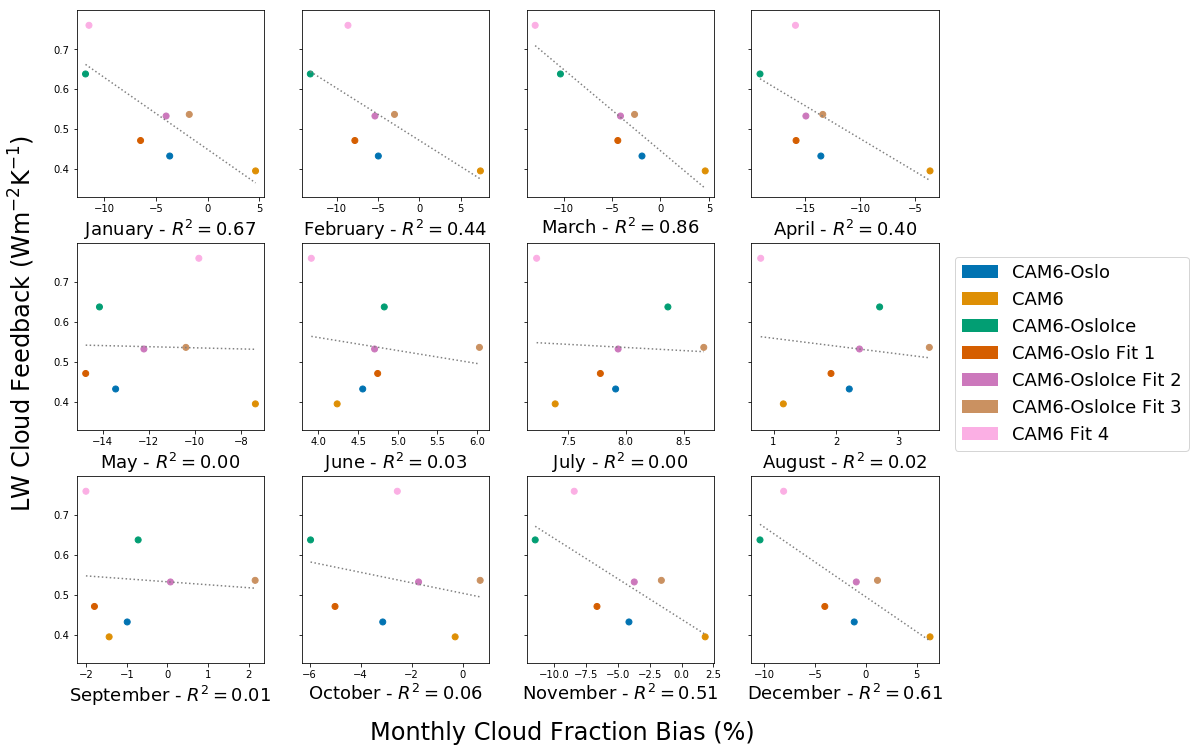

In [205]:
fig,axs = plt.subplots(nrows=3,ncols=4,figsize=(18,12),sharey=True)
fig.subplots_adjust(hspace=0.25)

# Subplot-wide axis labelling
fig.text(0.50, 0.030, 'Monthly Cloud Fraction Bias (%)', 
         va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=24)
fig.text(0.09, 0.30, 'LW Cloud Feedback (Wm$^{-2}$K$^{-1}$)',
         rotation='vertical', rotation_mode='anchor', fontsize=24)

for i,ax in enumerate(axs.flat):
    out = plot_correlation(i+1,['cloudlw_fb'],ax)

lgd = fig.legend(labels=labels,handles=lines,loc=(0.80, 0.40),fontsize=18)

fig.subplots_adjust(right=0.79)

In [206]:
to_png(fig,'month_LW_corrs')

### Plot 3-monthly LW correlations

/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.p

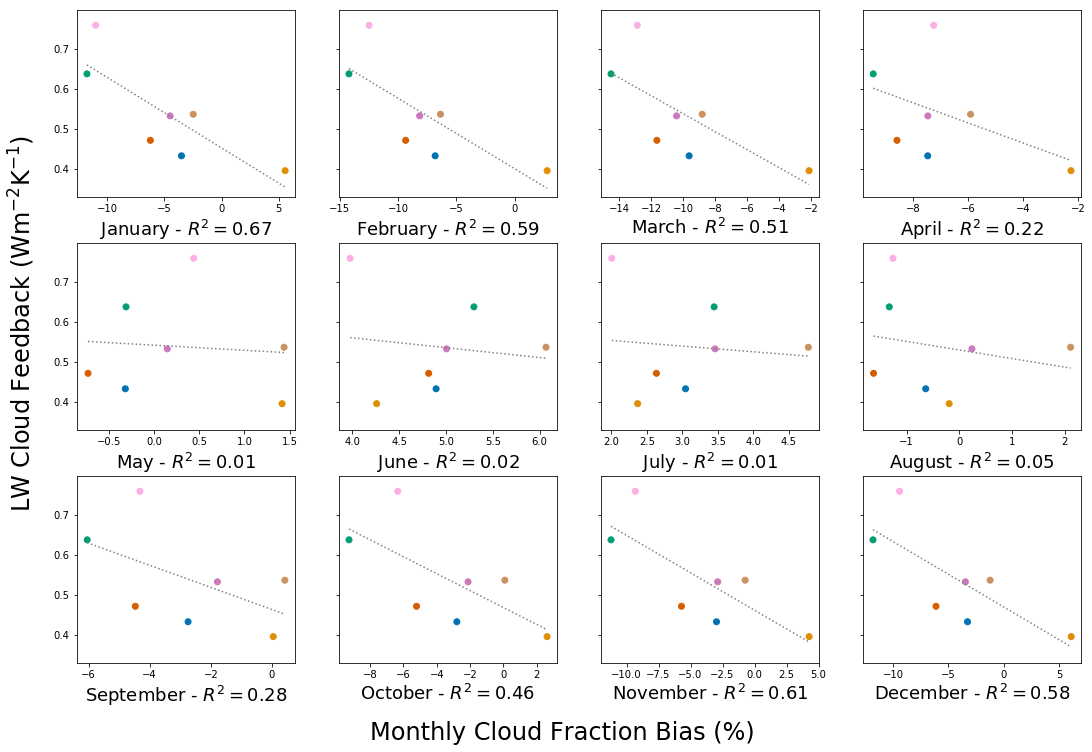

In [113]:
fig,axs = plt.subplots(nrows=3,ncols=4,figsize=(18,12),sharey=True)
fig.subplots_adjust(hspace=0.25)

# Subplot-wide axis labelling
fig.text(0.50, 0.030, 'Monthly Cloud Fraction Bias (%)', 
         va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=24)
fig.text(0.09, 0.30, 'LW Cloud Feedback (Wm$^{-2}$K$^{-1}$)',
         rotation='vertical', rotation_mode='anchor', fontsize=24)

for i,ax in enumerate(axs.flat):
    plot_correlation(i+1,['cloudlw_fb'],ax,totm=3)

### Plot monthly SW feedback correlations

/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.p

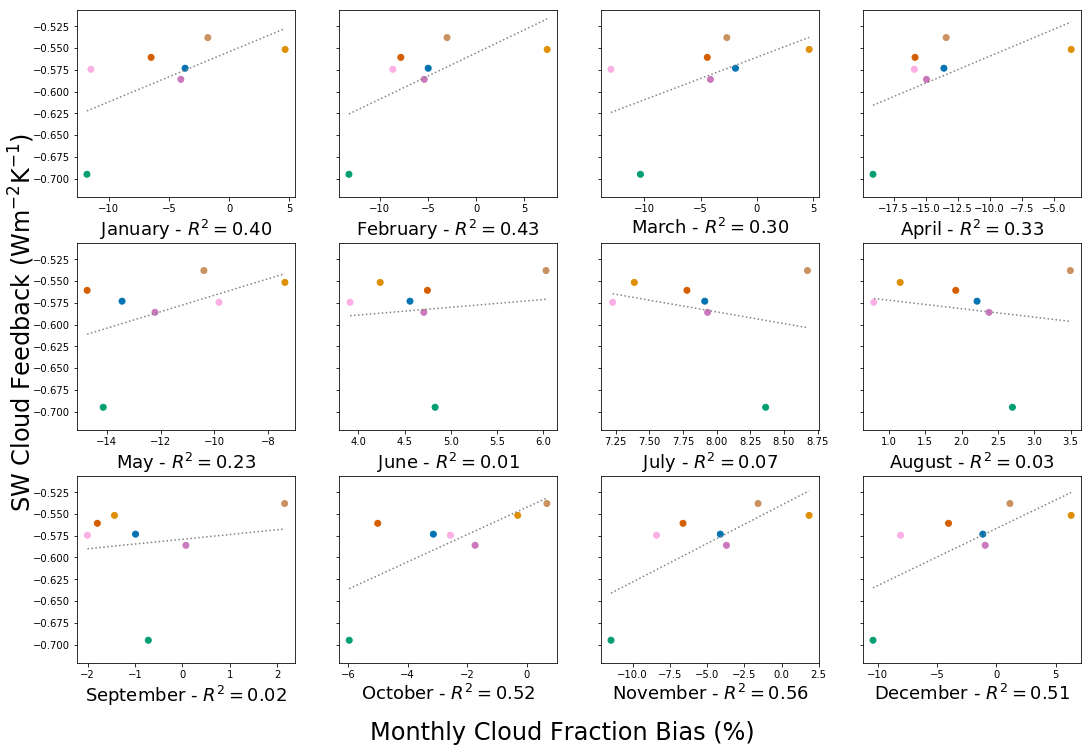

In [211]:
fig,axs = plt.subplots(nrows=3,ncols=4,figsize=(18,12),sharey=True)
fig.subplots_adjust(hspace=0.25)

# Subplot-wide axis labelling
fig.text(0.50, 0.030, 'Monthly Cloud Fraction Bias (%)', 
         va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=24)
fig.text(0.09, 0.30, 'SW Cloud Feedback (Wm$^{-2}$K$^{-1}$)',
         rotation='vertical', rotation_mode='anchor', fontsize=24)

for i,ax in enumerate(axs.flat):
    plot_correlation(i+1,['cloudsw_fb'],ax)

### Plot 3-monthly SW feedback correlations

/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.p

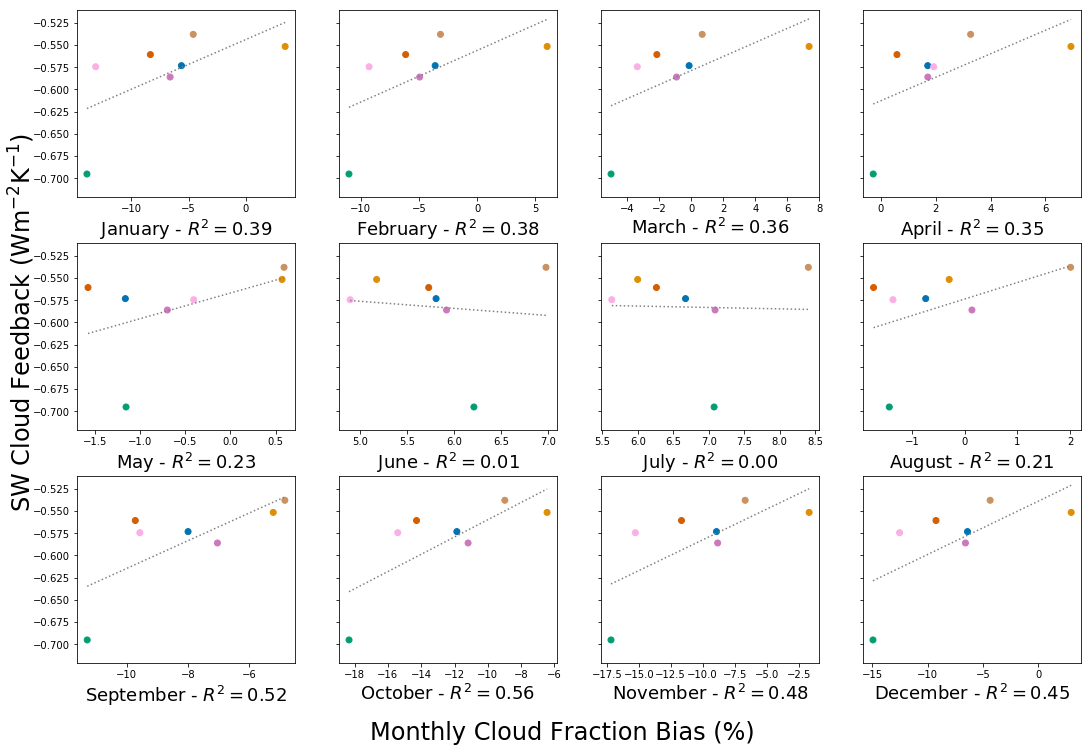

In [278]:
fig,axs = plt.subplots(nrows=3,ncols=4,figsize=(18,12),sharey=True)
fig.subplots_adjust(hspace=0.25)

# Subplot-wide axis labelling
fig.text(0.50, 0.030, 'Monthly Cloud Fraction Bias (%)', 
         va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=24)
fig.text(0.09, 0.30, 'SW Cloud Feedback (Wm$^{-2}$K$^{-1}$)',
         rotation='vertical', rotation_mode='anchor', fontsize=24)

for i,ax in enumerate(axs.flat):
    plot_correlation(i+1,['cloudsw_fb'],ax,totm=3)

### Plot monthly net cloud feedback correlations

/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.p

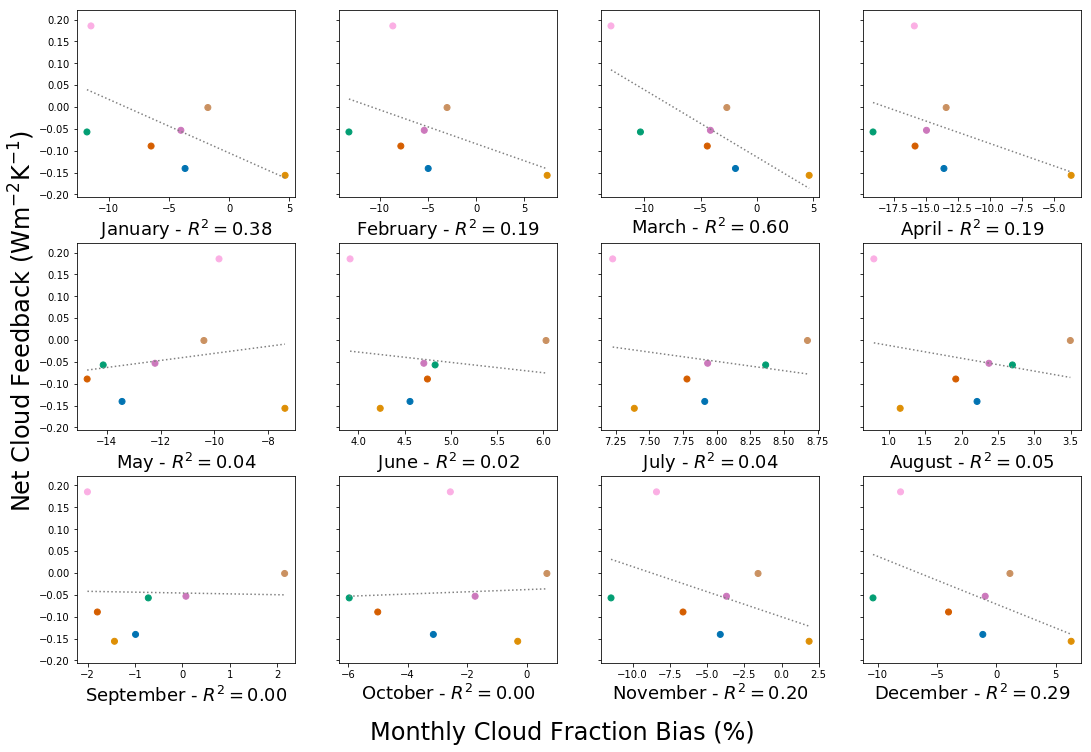

In [212]:
fig,axs = plt.subplots(nrows=3,ncols=4,figsize=(18,12),sharey=True)
fig.subplots_adjust(hspace=0.25)

# Subplot-wide axis labelling
fig.text(0.50, 0.030, 'Monthly Cloud Fraction Bias (%)', 
         va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=24)
fig.text(0.09, 0.30, 'Net Cloud Feedback (Wm$^{-2}$K$^{-1}$)',
         rotation='vertical', rotation_mode='anchor', fontsize=24)

for i,ax in enumerate(axs.flat):
    plot_correlation(i+1,['cloudsw_fb','cloudlw_fb'],ax)

### Plot 3-monthly net cloud feedback correlations

/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.p

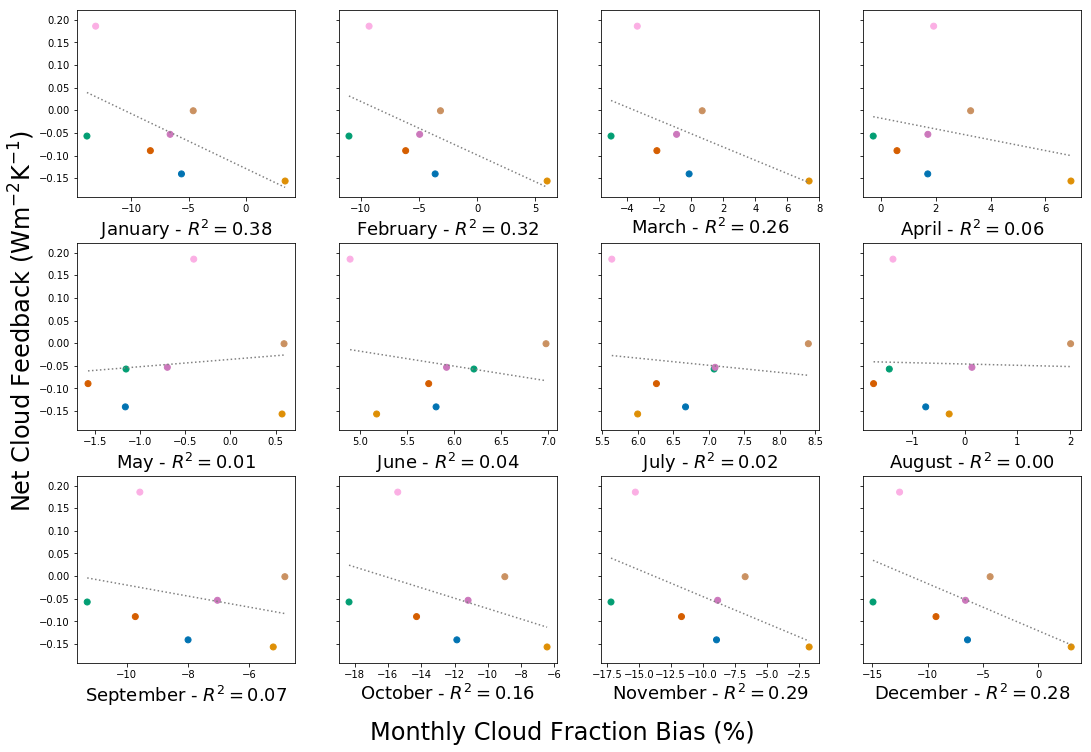

In [279]:
fig,axs = plt.subplots(nrows=3,ncols=4,figsize=(18,12),sharey=True)
fig.subplots_adjust(hspace=0.25)

# Subplot-wide axis labelling
fig.text(0.50, 0.030, 'Monthly Cloud Fraction Bias (%)', 
         va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=24)
fig.text(0.09, 0.30, 'Net Cloud Feedback (Wm$^{-2}$K$^{-1}$)',
         rotation='vertical', rotation_mode='anchor', fontsize=24)

for i,ax in enumerate(axs.flat):
    plot_correlation(i+1,['cloudsw_fb','cloudlw_fb'],ax,totm=3)

## Plot the stuff

/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


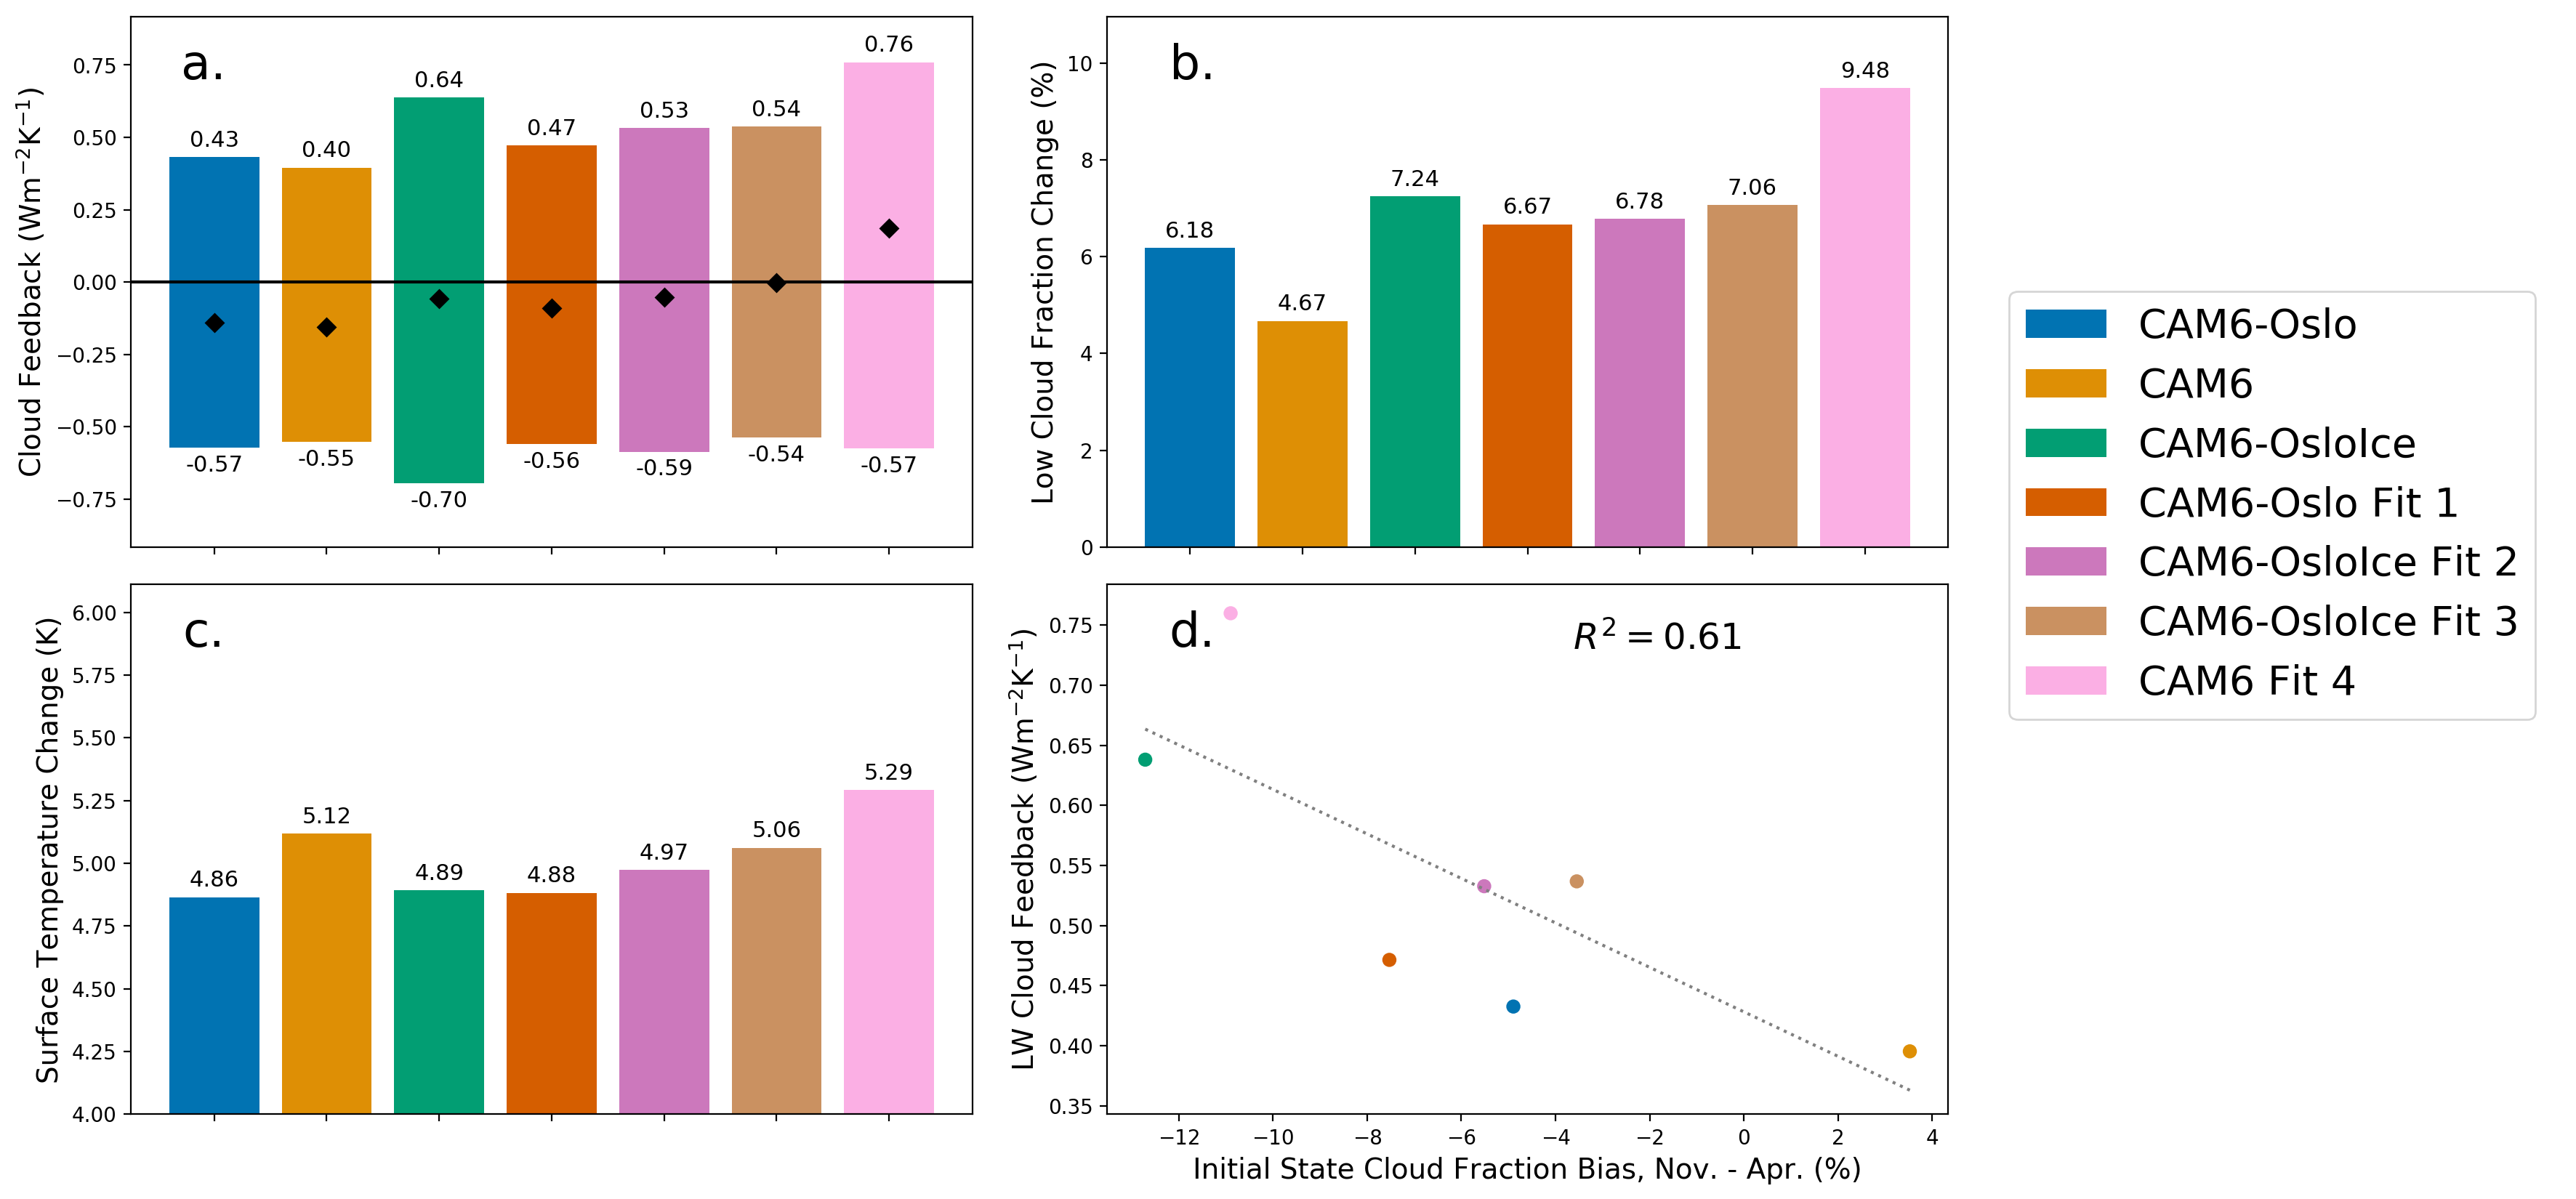

In [122]:
fig,axs = plt.subplots(nrows=2,ncols=2)#,sharey='row')
fig.set_figheight(10)
fig.set_figwidth(20)
fig.set_dpi(200)

axs = axs.flat
fig.subplots_adjust(wspace=0.16,hspace=0.07)

LWfb_plt,LWfb_axes,vals1 = barplot_single(case_dict2b,out2,'cloudlw_fb',
                                    labels=label_dict,ax=axs[0])

SWfb_plt,SWfb_axes,vals2 = barplot_single(case_dict2b,out2,'cloudsw_fb',
                                    labels=label_dict,ax=axs[0])

net_vals = {}
for i in vals1:
    net_vals[i] = vals1[i]+vals2[i]

out_test = axs[0].plot(np.arange(0,7),net_vals.values(),marker='D',color='black',linestyle="")
# autolabel4(out_test[0],axs[0])

dC_plt,dC_axes,_ = barplot_single(case_dict2b,out2,'filler',
                                  labels=label_dict,vals=dC_dict,ax=axs[1])

dT_plt,dT_axes,_ = barplot_single(case_dict2b,out2,'filler',
                                  labels=label_dict,vals=ts_dict,ax=axs[2])

# Plot correlation
plot_correlation(11,['cloudlw_fb'],totm=6,ax=axs[3])

# Mute existing labels and draw zero lines
for i,_ax in enumerate(axs):
    mute_ax(_ax)
    if i != 3:
        _ax.set_xticklabels([])
        _ax.set_ylim(1.1*np.array(_ax.get_ylim())) # Create space for labels

axs[0].hlines(0,axs[1].get_xlim()[0],axs[1].get_xlim()[1])#, linestyle='dashed',color='gray')
axs[0].set_xlim(axs[1].get_xlim()[0],axs[1].get_xlim()[1])
_ax0max = max(np.absolute(axs[0].get_ylim()))
axs[0].set_ylim(-1*_ax0max,_ax0max)
axs[0].set_ylabel('Cloud Feedback (Wm$^{-2}$K$^{-1}$)',fontsize=14)

axs[1].set_ylabel('Low Cloud Fraction Change (%)',fontsize=14)

axs[2].set_ylabel('Surface Temperature Change (K)',fontsize=14)
axs[2].set_ylim((4,axs[2].get_ylim()[1]))


axs[3].set_ylabel('LW Cloud Feedback (Wm$^{-2}$K$^{-1}$)',fontsize=14)
axs[3].set_xlabel('Initial State Cloud Fraction Bias, Nov. - Apr. (%)',fontsize=14)

fig.text(0.65, 0.44, '$R^2 = 0.61$', va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=18)

fig.text(0.15, 0.83, 'a.', va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=24)
fig.text(0.49, 0.83, 'b.', va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=24)
fig.text(0.15, 0.44, 'c.', va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=24)
fig.text(0.49, 0.44, 'd.', va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=24)

labels = []; lines = [] #Plot invisible bar graph but have the legends specified
for _key,_color in zip(case_dict2b,sns.color_palette('colorblind')):
    labels.append(label_dict[_key])
    _line = axs[0].bar(1,1,width=0,color=_color)
    lines.append(_line)

lgd = fig.legend(labels=labels,handles=lines,loc=(0.78, 0.40),fontsize=20)

fig.subplots_adjust(right=0.75)

In [115]:
to_png(fig,'feedback_winter_corr')

/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


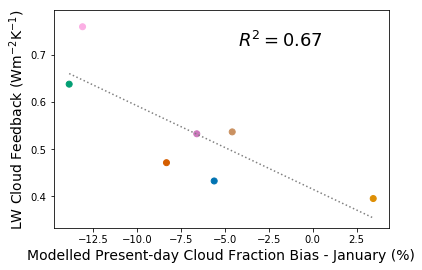

In [23]:
plot_correlation(1,['cloudlw_fb'],totm=3)

/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Text(0.65,0.74,'$R^2 = 0.86$')

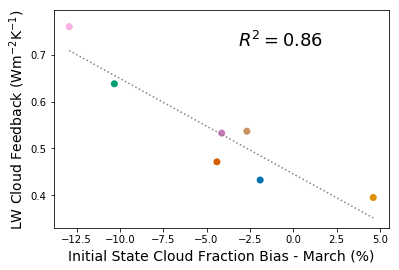

In [126]:
month = 3

month_names = {'1':'January','2':'February','3':'March',
              '4':'April','5':'May','6':'June',
              '7':'July','8':'August','9':'September',
              '10':'October','11':'November','12':'December'}

_,data = get_month(month,allmonth_clouddict)
month_name = month_names[str(month)]

# Do correlation
y = np.array(out2['cloudlw_fb'])
x = np.array(data) - float(arc_mean.sel(month=month))

model = LinearRegression()
model.fit(x.reshape(-1,1), y.reshape(-1,1))
# x_new = np.linspace(min(x), max(x), 100)
x_new = np.linspace(min(x), max(x), 100)
y_new = model.predict(x_new[:, np.newaxis])
y_pred = model.predict(x.reshape(-1,1))
categories = np.array([0, 1, 2, 3, 4, 5, 6, 7])
colormap = np.array(sns.color_palette('colorblind'))

# Plot correlation
fig,axs = plt.subplots(nrows=1,ncols=1)#,sharey='row')
axs.scatter(x, y, c=colormap[categories],marker='o')
axs.plot(x_new,y_new,c='grey',linestyle='dotted')

axs.set_ylabel('LW Cloud Feedback (Wm$^{-2}$K$^{-1}$)',fontsize=14)
axs.set_xlabel('Initial State Cloud Fraction Bias - %s (%%)' % month_name,fontsize=14)

fig.text(0.65, 0.74, '$R^2 = %.2f$' % r2_score(y, y_pred), va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=18)

## Functioning simple versions

NameError: name 'apr_totcloud' is not defined

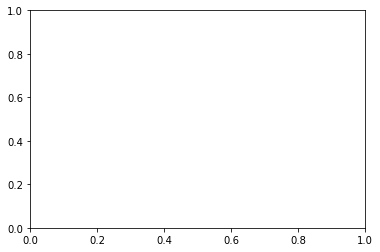

In [121]:
fig,axs = plt.subplots(nrows=1,ncols=1)#,sharey='row')

# Do correlation
y = np.array(out2['cloudlw_fb'])
x = np.array(apr_totcloud) - float(arc_mean.sel(month=4))

model = LinearRegression()
model.fit(x.reshape(-1,1), y.reshape(-1,1))
# x_new = np.linspace(min(x), max(x), 100)
x_new = np.linspace(min(x), 0, 100)
y_new = model.predict(x_new[:, np.newaxis])
y_pred = model.predict(x.reshape(-1,1))
categories = np.array([0, 1, 2, 3, 4, 5, 6, 7])
colormap = np.array(sns.color_palette('colorblind'))

# Plot correlation
axs.scatter(x, y, c=colormap[categories],marker='o')
axs.plot(x_new,y_new,c='grey',linestyle='dotted')

axs.set_ylabel('LW Cloud Feedback (Wm$^{-2}$K$^{-1}$)',fontsize=14)
axs.set_xlabel('Initial State Cloud Fraction Bias - April (%)',fontsize=14)

fig.text(0.65, 0.74, '$R^2 = %.2f$' % r2_score(y, y_pred), va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=18)

/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Text(0.65,0.74,'$R^2 = 0.25$')

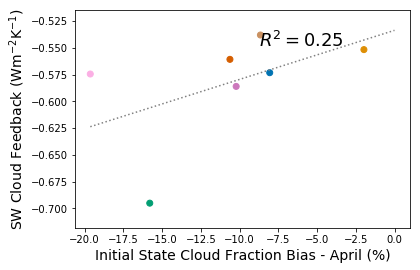

In [29]:
fig,axs = plt.subplots(nrows=1,ncols=1)#,sharey='row')

# Do correlation
y = np.array(out2['cloudsw_fb'])
x = np.array(apr_totcloud) - float(arc_mean.sel(month=4))

model = LinearRegression()
model.fit(x.reshape(-1,1), y.reshape(-1,1))
# x_new = np.linspace(min(x), max(x), 100)
x_new = np.linspace(min(x), 0, 100)
y_new = model.predict(x_new[:, np.newaxis])
y_pred = model.predict(x.reshape(-1,1))
categories = np.array([0, 1, 2, 3, 4, 5, 6, 7])
colormap = np.array(sns.color_palette('colorblind'))

# Plot correlation
axs.scatter(x, y, c=colormap[categories],marker='o')
axs.plot(x_new,y_new,c='grey',linestyle='dotted')

axs.set_ylabel('SW Cloud Feedback (Wm$^{-2}$K$^{-1}$)',fontsize=14)
axs.set_xlabel('Initial State Cloud Fraction Bias - April (%)',fontsize=14)

fig.text(0.65, 0.74, '$R^2 = %.2f$' % r2_score(y, y_pred), va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=18)

/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Text(0.65,0.74,'$R^2 = 0.65$')

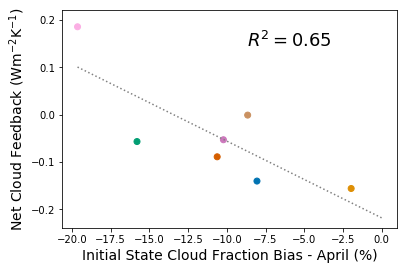

In [34]:
fig,axs = plt.subplots(nrows=1,ncols=1)#,sharey='row')

# Do correlation
y = np.array(np.array(out2['cloudsw_fb']) + np.array(out2['cloudlw_fb']))
x = np.array(apr_totcloud) - float(arc_mean.sel(month=4))

model = LinearRegression()
model.fit(x.reshape(-1,1), y.reshape(-1,1))
# x_new = np.linspace(min(x), max(x), 100)
x_new = np.linspace(min(x), 0, 100)
y_new = model.predict(x_new[:, np.newaxis])
y_pred = model.predict(x.reshape(-1,1))
categories = np.array([0, 1, 2, 3, 4, 5, 6, 7])
colormap = np.array(sns.color_palette('colorblind'))

# Plot correlation
axs.scatter(x, y, c=colormap[categories],marker='o')
axs.plot(x_new,y_new,c='grey',linestyle='dotted')

axs.set_ylabel('Net Cloud Feedback (Wm$^{-2}$K$^{-1}$)',fontsize=14)
axs.set_xlabel('Initial State Cloud Fraction Bias - April (%)',fontsize=14)

fig.text(0.65, 0.74, '$R^2 = %.2f$' % r2_score(y, y_pred), va='bottom', ha='center', rotation='horizontal', 
         rotation_mode='anchor', fontsize=18)